# notebook for imputations of IBEX data from single cell RNA and CiteSeq

In [1]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
ibex = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/IBEX/all_ibex_3D_v1_raw.h5ad") # load most recent IBEX object 
gex = sc.read("/nfs/team205/ny1/ThymusSpatialAtlas/Figure1/annotation_done/Thymus_Atlas_v8.h5ad") # load most recent atlas object 

# Step 0 - objects cleanup

## Cleanup gex 

In [3]:
gex = gex[gex.obs['cell_type_level_0']!='FailQC'] # remove bad cells
anno = 'anno_CITE_4v6'
gex


View of AnnData object with n_obs × n_vars = 498018 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_cou

In [4]:
# update other cells from non T cells 
gex.obs[anno] = gex.obs.apply(lambda x: np.nan if x['age_group'] == 'fetal' else
                                                            x['cell_type_level_4'] if x['anno_CITE_4v5'] == 'B' else 
                                                            x['cell_type_level_4'] if x['anno_CITE_4v5'] == 'DC' else 
                                                            x['anno_CITE_4v5'] if x['study'] == 'SpatialAtlas-Taghon' else
                                                            x['cell_type_level_4'] if x['cell_type_level_0'] != 'T' else
                                         np.nan, axis = 1)

gex = gex[~gex.obs[anno].isna()]
gex = gex[gex.obs[anno] != 'nan']
gex.obs[anno] = gex.obs[anno].astype('category')

prolif_cells = ['DC1-Prolif', 'DC2-Prolif', 'pDC-Prolif', 'PeriloFb-Prolif', 'ProlifPericyte','mcTEC-Prolif',
               'B-Prolif']
fet_specific = ['pro_B', 'late_pro_B', 'large_pre_B', 'small_pre_B', 'CMP', 'GMP', 'InterloFb-COL9A3',
                'fetFB-NKX2-5', 'fetFB-CCL21','fetFB-RSPO2', 'Mesothelium', 'mcTEC-Prolif',
               'T_NK_fetal', ]
unclear = ['T_DP(Q)-HSPH1','T_SP8or4','T_SP-HSP','T_DN(Q)-stress_1','T_DN(Q)-stress_2','T_DN(Q)-intermediate','T_Treg-intermediate']
to_remove = set(gex.obs[anno].value_counts().loc[gex.obs[anno].
                                                                      value_counts()<=40].index.tolist()+
            prolif_cells + fet_specific + unclear)

gex = gex[~gex.obs[anno].isin(to_remove),:].copy()
# take cells from each sample 
def subset_by_anno(adata, cluster_key , target_cells=20000):
    adatas = [adata[adata.obs[cluster_key] == clust].copy() for clust in adata.obs[cluster_key].cat.categories]
    for dat in adatas:
        if dat.n_obs > target_cells:
            sc.pp.subsample(dat, n_obs=target_cells)
    adata_sub = adatas[0].concatenate(*adatas[1:])
    return adata_sub

gex = subset_by_anno(gex, anno,target_cells=10000)

/tmp/ipykernel_4025/2788159333.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[anno] = gex.obs.apply(lambda x: np.nan if x['age_group'] == 'fetal' else
/tmp/ipykernel_4025/2788159333.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[anno] = gex.obs[anno].astype('category')


In [5]:
# see cell proportions
anno = 'anno_CITE_4v6'
for i, j in gex.obs[anno].value_counts().items():
    print(str(i) + ' ' + str(j))

DP_4hi8lo 10000
DP(Q)_rearr 10000
DP(P)_early 10000
committed_CD4pos 6497
DP_pos_sel 6153
SP_CD4_semimature 5499
DP(Q)_CD199 5337
SP_CD4_immature 4681
DP(Q)_early 4672
SP_CD8_semimature 4495
DP(Q)_CD99_CD31lo 4115
committed_CD4neg 3843
DP_early_CD31 3020
DP(Q)_CD99_CD31hi 2927
mTECI 2880
mcTEC 2764
cTECIII 2153
SP_Treg_mature 2119
SP_CD8_immature 2030
cTECI 1967
SP_Treg_immature 1658
cTECII 1589
SMC 1567
EC-Ven 1539
B-memory 1366
PeriloFb 1320
TEC-neuro 1235
InterloFb 1231
B-naive 1002
DP(Q)_HSPH1 979
EC-Cap 865
CD8aaI_immature 827
mTECII 789
mTECIII 742
EC-Art 720
SP_CD4_mature 714
CD8aaII_mature 712
CD8aaII_immature 646
SP_Treg_PD1 575
medFb-RGS5 552
TEC-myo 500
CD8aaI_mature 487
TEC-cilliated 474
DP(P)_late 378
SP_CD8_mature 371
medFB-MHCIIh 362
gdT_semimature 354
SP_Treg_CD8 353
committed_CD4neg(P) 335
Pericyte 334
mTECI-trans 325
pDC 294
DC1 269
aDC3 264
NK_tr_itg_hi 192
gdT_immature 189
medFb 180
Pericyte_CCL19 171
SP_Treg_recirc 168
uncommitted 163
NKT_dev 149
committed_CD4pos(P

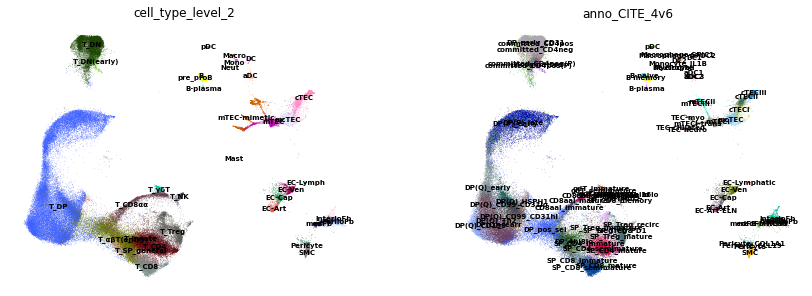

In [6]:
sc.pl.umap(gex, color = ['cell_type_level_2', 'anno_CITE_4v6'], legend_loc = "on data", 
          legend_fontsize = 7, frameon = False)

In [7]:
gex

AnnData object with n_obs × n_vars = 123873 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

## Pre process IBEX

In [8]:
ibex = subset_by_anno(ibex, 'sample' , target_cells=100000)
ibex

AnnData object with n_obs × n_vars = 764448 × 45
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    layers: 'counts'

In [9]:
# translate the protein marker name to it's corresponding gene in the gex data  
protein_to_gene = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'CD99',
    'CD163_mean': 'CD163',
    'CD11C_mean': 'ITGAX',
    'CD8_mean': 'CD8A',
    'CD3_mean': 'CD3D',
    'CD5_mean': 'CD5',
    'CD20_mean': 'MS4A1',
    'CD34_mean': 'CD34',
    'CD7_mean': 'CD7',
    'CD31_mean': 'PECAM1',
    'CD39_mean': 'ENTPD1',
    'CD4_mean': 'CD4',
    'VA7.2_mean': 'TRAV7',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'HLA-DRB1',
    'CD123_mean': 'IL3RA',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'ITGA1',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'PTPRC',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'TCRG',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'ITGA6',
    'CD15_0_mean': None
}

# Create a new column in anndata.var for protein names
ibex.var['gene_name'] = ''
ibex.var['protein_name'] = ''

# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    protein_name = row.name
    if protein_name in protein_to_gene:
        gene_name = protein_to_gene[protein_name]
        ibex.var.loc[idx, 'gene_name'] = gene_name
        ibex.var.loc[idx, 'protein_name'] = protein_name

# Print the updated anndata.var DataFrame
print(ibex.var)

                gene_name     protein_name
nuclear_mean         None     nuclear_mean
CHGA_mean            CHGA        CHGA_mean
CD99_mean            CD99        CD99_mean
CD163_mean          CD163       CD163_mean
CD11C_mean          ITGAX       CD11C_mean
CD8_mean             CD8A         CD8_mean
CD3_mean             CD3D         CD3_mean
CD5_mean              CD5         CD5_mean
CD20_mean           MS4A1        CD20_mean
CD34_mean            CD34        CD34_mean
CD7_mean              CD7         CD7_mean
CD31_mean          PECAM1        CD31_mean
CD39_mean          ENTPD1        CD39_mean
CD4_mean              CD4         CD4_mean
VA7.2_mean          TRAV7       VA7.2_mean
TUBB3_mean          TUBB3       TUBB3_mean
CD206_mean           MRC1       CD206_mean
SPARC_mean          SPARC       SPARC_mean
LAMIN_A_mean         LMNA     LAMIN_A_mean
HLADR_mean       HLA-DRB1       HLADR_mean
CD123_mean          IL3RA       CD123_mean
DEC205_mean          LY75      DEC205_mean
AQP1_mean  

In [10]:
# Filter out non-gene features and update var_names
gene_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in protein_to_gene and protein_to_gene[feature] is not None:
        gene_features.append(feature)
        new_var_names.append(protein_to_gene[feature])

# Create a new AnnData object with gene features
ibex_gene = ibex[:, gene_features].copy()

# Update var_names in the new AnnData object
ibex_gene.var_names = new_var_names

# Print the new AnnData object
ibex_gene.var_names


Index(['CHGA', 'CD99', 'CD163', 'ITGAX', 'CD8A', 'CD3D', 'CD5', 'MS4A1',
       'CD34', 'CD7', 'PECAM1', 'ENTPD1', 'CD4', 'TRAV7', 'TUBB3', 'MRC1',
       'SPARC', 'LMNA', 'HLA-DRB1', 'IL3RA', 'LY75', 'AQP1', 'MKI67', 'AIRE',
       'ITGA1', 'KRT10', 'KRT15', 'LUM', 'LYVE1', 'VIM', 'KRT14', 'ANXA1',
       'FUT4', 'PTPRC', 'SYP', 'TCRG', 'KRT8', 'ACTA2', 'KRT5', 'FOXP3', 'DES',
       'ITGA6'],
      dtype='object')

In [11]:
# filter and batch correct ibex data 
ibex_gene = ibex_gene[ibex_gene.obs['manual_bin_cma_v2'].dropna().index]
ibex_gene.X = np.nan_to_num(ibex_gene.X, nan=0)
sc.pp.combat(ibex_gene, key='sample', inplace=True) # batch correct 
ibex_gene.X = np.nan_to_num(ibex_gene.X, nan=0)


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [12]:
# plot PCA for sanity 
sc.pp.pca(ibex_gene, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_gene,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)
ibex_gene.var['gene_name'] = ibex_gene.var['gene_name'].astype(str)
ibex_gene.var = ibex_gene.var.set_index("gene_name")
ibex_gene.var

In [13]:
# check how many genes are overlapping 
len(set(ibex_gene.var_names).intersection(gex.var_names))

41

In [14]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
gex.write_h5ad('pre_patcher_gex.h5ad')
ibex_gene.write_h5ad('pre_patcher_ibex.h5ad')
ibex.write_h5ad('pre_patcher_ibex_raw.h5ad')

# end of preprocessing 

# Step 1- Run patcher on all cells 

In [1]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 

os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
gex = sc.read_h5ad('pre_patcher_gex.h5ad')
ibex_gene = sc.read_h5ad('pre_patcher_ibex.h5ad')

In [2]:
anno = 'anno_CITE_4v6'
# run pisser on individual samples without batch correctino 
import time
import scanpy as sc

# Get unique samples
unique_samples = ibex_gene.obs['sample'].unique()

# Dictionary to hold output for each sample
out_dict = {}

# Run the function for each sample and append the result to the list
for sample in unique_samples:
    start_time = time.time()
    # subset sample
    ibex_gene_sample = ibex_gene[ibex_gene.obs['sample'] == sample]
    # scale each sample 
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1000))
    ibex_gene_sample.X = scaler.fit_transform(ibex_gene_sample.X)
    # remove counts smaller than 1 
    # run patcher 
    out_sample = ip.patch(iss=ibex_gene_sample, gex=gex, obs_to_take=anno, computation='cKDTree', neighbours=30,obsm_fraction=True,chunk_size=200000)
    out_dict[sample] = out_sample
    end_time = time.time()
    print(f"Processed sample {sample} in {end_time - start_time} seconds")

# Concatenate all the results
out = sc.concat(out_dict, join='outer')

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_06 in 202.97012448310852 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_07 in 205.0252664089203 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_08 in 195.90581345558167 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_09 in 211.1143651008606 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_10 in 192.23135375976562 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_11 in 202.88650703430176 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_12 in 195.60451745986938 seconds


/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_13 in 145.1233367919922 seconds


In [13]:
out.obs[anno] = out.obs[anno].astype('category')

def plot_cell_matrix(
    adata,
    x_anno,
    y_anno,
    x_anno_groups,
    y_anno_groups,
    figsize = [4,4],
    cmap = 'viridis',
):
    
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Group by y_anno and x_anno, then count
    cell_type_counts = adata.obs.groupby([y_anno, x_anno]).size().rename('cell_type_count').reset_index()

    # Calculate sum of counts for each y_anno group
    group_totals = cell_type_counts.groupby(x_anno)['cell_type_count'].transform('sum')

    # Divide each count by the total count of its group to get the proportion
    cell_type_counts['cell_type_frequency'] = cell_type_counts['cell_type_count'] / group_totals

    # Pivot data for heatmap
    pivot_df_cell_type = cell_type_counts.pivot(index=x_anno, columns=y_anno, values='cell_type_frequency')

    # Reorder the clusters
    pivot_df_cell_type = pivot_df_cell_type.reindex(x_anno_groups)
    pivot_df_cell_type = pivot_df_cell_type.reindex(index=x_anno_groups, columns=y_anno_groups)
    pivot_df_cell_type_plot = pivot_df_cell_type.loc[:,y_anno_groups]
    pivot_df_cell_type_plot = pivot_df_cell_type_plot.div(pivot_df_cell_type_plot.max(axis=0), axis=1)

    # Calculate the number of unique categories in x_anno and y_anno
    n_x_anno = len(adata.obs[x_anno].unique())
    n_y_anno = len(adata.obs[y_anno].unique())

    # Set the plot size to be proportional to the number of categories
    fig, ax = plt.subplots(figsize=figsize)

    # Create heatmap
    sns.heatmap(pivot_df_cell_type_plot, cmap=cmap)

    ax.set_title('Cell Type Normalized Frequencies')
    ax.grid(False)  # This will remove gridlines

    plt.tight_layout()
    plt.show()  

In [64]:
def plot_cell_dotplot(
    adata,
    x_anno,
    y_anno,
    x_anno_groups,
    y_anno_groups,
    figsize=[4, 4],
    cmap='viridis',
    save_name=None,
):

    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # Group by y_anno and x_anno, then count
    cell_type_counts = adata.obs.groupby([y_anno, x_anno]).size().rename('cell_type_count').reset_index()

    # Calculate sum of counts for each y_anno group
    group_totals = cell_type_counts.groupby(x_anno)['cell_type_count'].transform('sum')

    # Divide each count by the total count of its group to get the proportion
    cell_type_counts['cell_type_frequency'] = cell_type_counts['cell_type_count'] / group_totals

    # Pivot data for dot plot
    pivot_df_cell_type = cell_type_counts.pivot(index=x_anno, columns=y_anno, values='cell_type_frequency')

    # Reorder the clusters
    pivot_df_cell_type = pivot_df_cell_type.reindex(x_anno_groups)
    pivot_df_cell_type = pivot_df_cell_type.reindex(index=x_anno_groups, columns=y_anno_groups)

    # Get the max value for size normalization across the entire dataset
    max_size_value = pivot_df_cell_type.max().max()

    n_x_anno = len(x_anno_groups)
    n_y_anno = len(y_anno_groups)

    fig, ax = plt.subplots(figsize=figsize)

    for j in range(n_y_anno):
        # Normalize color based on the maximum value in each y_anno group
        max_color_value = pivot_df_cell_type.iloc[:, j].max()
        norm_color = mcolors.Normalize(vmin=0, vmax=max_color_value)
        cmap_color = cm.get_cmap(cmap)

        for i in range(n_x_anno):
            x_val = j
            y_val = i
            size = pivot_df_cell_type.iloc[i, j]
            if pd.notna(size):  # Ensure that the value is not NaN
                normalized_size = size / max_size_value
                ax.scatter(x_val, y_val, s=normalized_size * 500, c=[cmap_color(norm_color(size))])

    ax.set_title('Cell Type Normalized Frequencies')
    ax.set_xticks(range(n_y_anno))
    ax.set_yticks(range(n_x_anno))
    ax.set_xticklabels(y_anno_groups, rotation=90) # Rotate the x-labels
    ax.set_yticklabels(x_anno_groups)

    # Add space between the extreme values along the x-axis
    plt.xlim(-1, n_y_anno)

    # Remove grid
    ax.grid(False)

    # Invert the y-axis to display the categories in the desired order
    ax.invert_yaxis()

    plt.tight_layout()

    # Save the figure if save_name is specified
    if save_name:
        plt.savefig(save_name)

    plt.show()

In [65]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/ImageSpot/')
import imagespot as ims

In [66]:
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level I','Cortical level II','Cortical level III','Cortical CMJ','Medullar CMJ','Medullar level I','Medullar level II','Medullar level III']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
out.obs = ims.bin_axis(ct_order ,ct2_values,out.obs,'cma_v2')   
out.obs.loc[out.obs['annotation_lv_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
out.obs['manual_bin_cma_v2'] = out.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
out.obs['manual_bin_cma_v2'].value_counts()


Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level I= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level II= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level III= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level I= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level II= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level III= (0.7=<cma_v2)


Cortical level I      222524
Cortical level II     154972
Sub-Capsular          109138
Cortical level III     70208
Capsular               47818
Cortical CMJ           45049
Medullar CMJ           35639
Medullar level III     31844
Medullar level I       27340
Medullar level II      19916
Name: manual_bin_cma_v2, dtype: int64

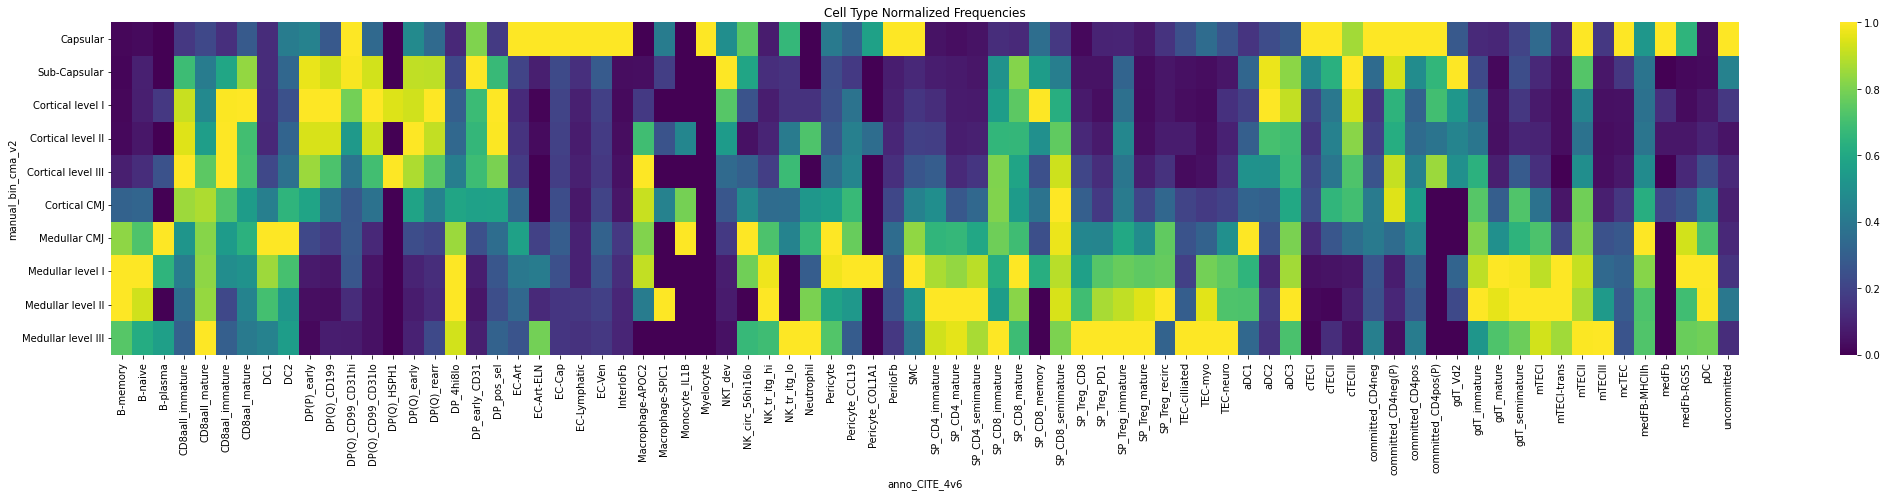

In [16]:
# plot results on axis 
cells = out.obs[anno].cat.categories.tolist()
ct_order = ['Capsular','Sub-Capsular', 'Cortical level I', 'Cortical level II', 'Cortical level III', 'Cortical CMJ', 'Medullar CMJ', 'Medullar level I', 'Medullar level II', 'Medullar level III']
plot_cell_matrix(out, y_anno = anno ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[30,7])

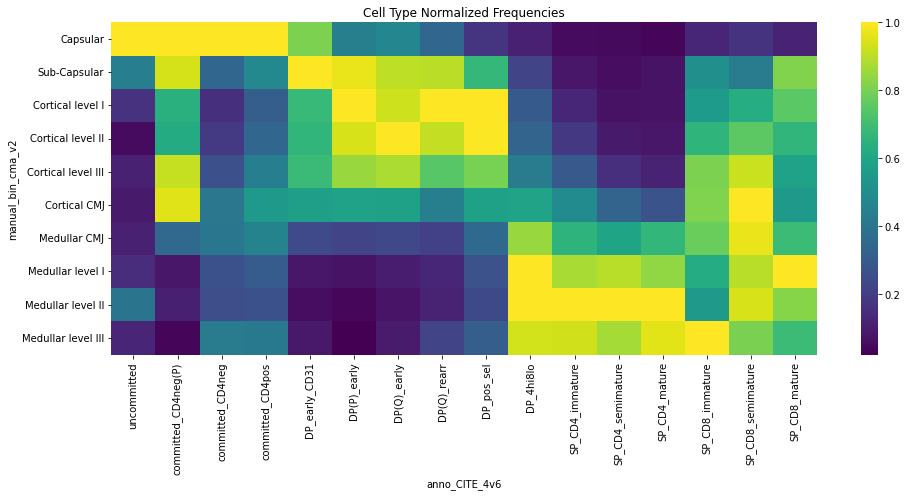

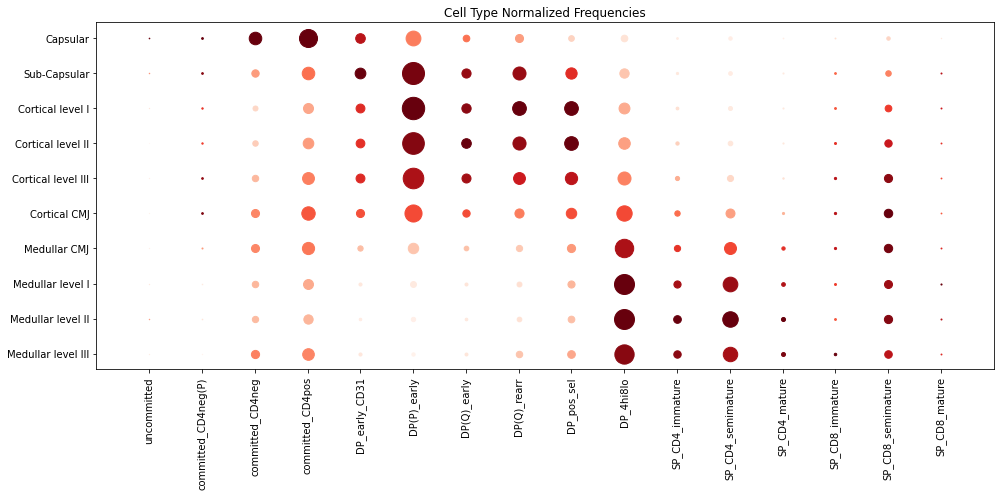

In [17]:
cells = ['uncommitted','committed_CD4neg(P)','committed_CD4neg','committed_CD4pos', 'DP_early_CD31','DP(P)_early', 'DP(Q)_early', 'DP(Q)_rearr','DP_pos_sel','DP_4hi8lo', 'SP_CD4_immature', 'SP_CD4_semimature', 'SP_CD4_mature','SP_CD8_immature','SP_CD8_semimature','SP_CD8_mature',]
fraction = 0
plot_cell_dotplot(out[out.obs['anno_CITE_4v6_fraction']>fraction], y_anno = 'anno_CITE_4v6' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[14,7],cmap='Reds')

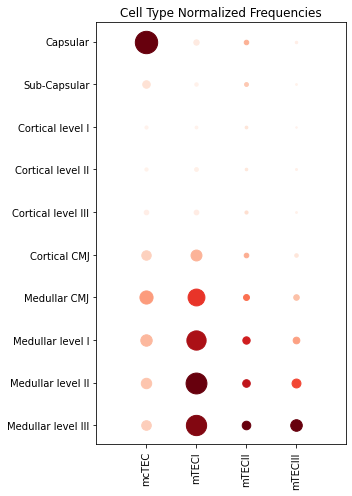

In [18]:
cells = ['mcTEC','mTECI','mTECII','mTECIII']
fraction = 0.75
plot_cell_dotplot(out[out.obs['anno_CITE_4v6_fraction']>fraction], y_anno = 'anno_CITE_4v6' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[5,7],cmap='Reds',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/mTECs_f'+str(fraction)+'_IBEX_impute.pdf')

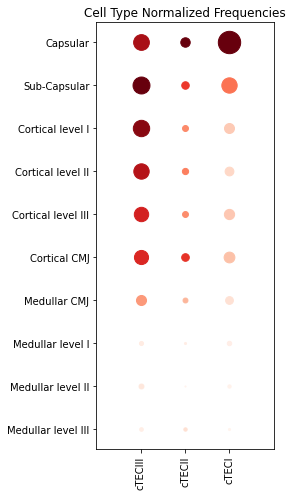

In [19]:
cells = ['cTECIII','cTECII','cTECI']
fraction = 0
plot_cell_dotplot(out[out.obs['anno_CITE_4v6_fraction']>fraction], y_anno = 'anno_CITE_4v6' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[4,7],cmap='Reds',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/cTECs_f'+str(fraction)+'_IBEX_impute.pdf')

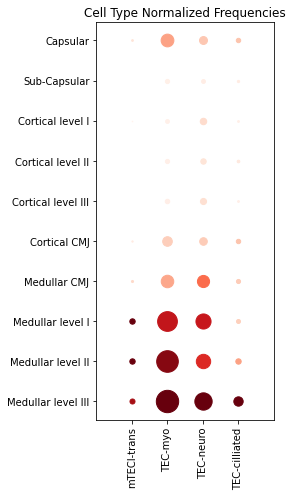

In [20]:
# special Tecs 
cells = ['mTECI-trans','TEC-myo','TEC-neuro','TEC-cilliated']
fraction = 0.25
plot_cell_dotplot(out[out.obs['anno_CITE_4v6_fraction']>fraction], y_anno = 'anno_CITE_4v6' ,x_anno = 'manual_bin_cma_v2',x_anno_groups =ct_order ,y_anno_groups = cells,figsize=[4,7],cmap='Reds',save_name='/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/cTECs_special_f'+str(fraction)+'_IBEX_impute.pdf')

In [21]:
# save output 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
out.write_h5ad('out_RNA_1m_KNN30_v2.h5ad')

# Step 2 - keep only T cells and map to CITEseq data and RNA data again 

In [ ]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')


In [ ]:
anno = 'anno_CITE_4v6'
gex = sc.read_h5ad('pre_patcher_gex.h5ad')
ibex = sc.read_h5ad('pre_patcher_ibex_raw.h5ad')
out = sc.read_h5ad('out_RNA_1m_KNN30_v2.h5ad')

In [26]:
ibex_to_cite = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'cite_CD99',
    'CD163_mean': 'cite_CD163',
    'CD11C_mean': 'cite_CD11c',
    'CD8_mean': 'cite_CD8',
    'CD3_mean': 'cite_CD3',
    'CD5_mean': 'cite_CD5',
    'CD20_mean': 'cite_CD20',
    'CD34_mean': 'cite_CD34',
    'CD7_mean': 'cite_CD7',
    'CD31_mean': 'cite_CD31',
    'CD39_mean': 'cite_CD39',
    'CD4_mean': 'cite_CD4',
    'VA7.2_mean': 'cite_TCR-Va7.2',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'cite_HLA.DR',
    'CD123_mean': 'cite_CD123',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'cite_CD49a',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'cite_CD45',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'cite_TCRgd',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'cite_CD49f',
    'CD15_0_mean': None
}

# translate the protein marker name to it's corresponding gene in the gex data  
ibex_to_rna = {
    'nuclear_mean': None,
    'CHGA_mean': 'CHGA',
    'CD99_mean': 'CD99',
    'CD163_mean': 'CD163',
    'CD11C_mean': 'ITGAX',
    'CD8_mean': 'CD8A',
    'CD3_mean': 'CD3D',
    'CD5_mean': 'CD5',
    'CD20_mean': 'MS4A1',
    'CD34_mean': 'CD34',
    'CD7_mean': 'CD7',
    'CD31_mean': 'PECAM1',
    'CD39_mean': 'ENTPD1',
    'CD4_mean': 'CD4',
    'VA7.2_mean': 'TRAV7',
    'TUBB3_mean': 'TUBB3',
    'CD206_mean': 'MRC1',
    'SPARC_mean': 'SPARC',
    'LAMIN_A_mean': 'LMNA',
    'HLADR_mean': 'HLA-DRB1',
    'CD123_mean': 'IL3RA',
    'DEC205_mean': 'LY75',
    'AQP1_mean': 'AQP1',
    'KI67_mean': 'MKI67',
    'AIRE_mean': 'AIRE',
    'CD49A_mean': 'ITGA1',
    'KERATIN_10_mean': 'KRT10',
    'KERATIN_15_mean': 'KRT15',
    'LUMICAN_mean': 'LUM',
    'LYVE1_mean': 'LYVE1',
    'VIMENTIN_mean': 'VIM',
    'KERATIN_14_mean': 'KRT14',
    'ANNEXIN1_mean': 'ANXA1',
    'CD15_mean': 'FUT4',
    'CD45_mean': 'PTPRC',
    'SYP_mean': 'SYP',
    'TCRGD_mean': 'TCRG',
    'KERATIN_8_mean': 'KRT8',
    'PANCYTO_mean': None,
    'ASMA_mean': 'ACTA2',
    'KERATIN_5_mean': 'KRT5',
    'FOXP3_mean': 'FOXP3',
    'DESMIN_mean': 'DES',
    'CD49F_mean': 'ITGA6',
    'CD15_0_mean': None
}


# Create a new column in anndata.var for protein names
ibex.var['cite_name'] = ''
ibex.var['rna_name'] = ''
ibex.var['ibex_name'] = ''

In [27]:
# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    ibex_name = row.name
    if ibex_name in ibex_to_cite:
        cite_name = ibex_to_cite[ibex_name]
        ibex.var.loc[idx, 'cite_name'] = cite_name
        
# Iterate over each row in anndata.var and map protein names to gene names
for idx, row in ibex.var.iterrows():
    ibex_name = row.name
    if ibex_name in ibex_to_rna:
        rna_name = ibex_to_rna[ibex_name]
        ibex.var.loc[idx, 'rna_name'] = rna_name
        ibex.var.loc[idx, 'ibex_name'] = ibex_name
        
# Print the updated anndata.var DataFrame
print(ibex.var)

                gene_name     protein_name       cite_name  rna_name  \
nuclear_mean          NaN     nuclear_mean            None      None   
CHGA_mean            CHGA        CHGA_mean            CHGA      CHGA   
CD99_mean            CD99        CD99_mean       cite_CD99      CD99   
CD163_mean          CD163       CD163_mean      cite_CD163     CD163   
CD11C_mean          ITGAX       CD11C_mean      cite_CD11c     ITGAX   
CD8_mean             CD8A         CD8_mean        cite_CD8      CD8A   
CD3_mean             CD3D         CD3_mean        cite_CD3      CD3D   
CD5_mean              CD5         CD5_mean        cite_CD5       CD5   
CD20_mean           MS4A1        CD20_mean       cite_CD20     MS4A1   
CD34_mean            CD34        CD34_mean       cite_CD34      CD34   
CD7_mean              CD7         CD7_mean        cite_CD7       CD7   
CD31_mean          PECAM1        CD31_mean       cite_CD31    PECAM1   
CD39_mean          ENTPD1        CD39_mean       cite_CD39    EN

In [28]:
# Filter out non-cite features and update var_names
cite_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in ibex_to_cite and ibex_to_cite[feature] is not None:
        cite_features.append(feature)
        new_var_names.append(ibex_to_cite[feature])

# Create a new AnnData object with gene features
ibex_cite = ibex[:, cite_features].copy()

# Update var_names in the new AnnData object
ibex_cite.var_names = new_var_names

# Print the new AnnData object
ibex_cite = ibex_cite[ibex_cite.obs['manual_bin_cma_v2'].dropna().index]
ibex_cite.X = np.nan_to_num(ibex_cite.X, nan=0)
sc.pp.combat(ibex_cite, key='sample', inplace=True) # batch correct 
ibex_cite.X = np.nan_to_num(ibex_cite.X, nan=0)
ibex_cite.var_names
sc.pp.pca(ibex_cite, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_cite,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)

In [29]:
# Filter out non-rna features and update var_names
rna_features = []
new_var_names = []
for feature in ibex.var_names:
    if feature in ibex_to_rna and ibex_to_rna[feature] is not None:
        rna_features.append(feature)
        new_var_names.append(ibex_to_rna[feature])

# Create a new AnnData object with gene features
ibex_rna = ibex[:, rna_features].copy()

# Update var_names in the new AnnData object
ibex_rna.var_names = new_var_names

# Print the new AnnData object
ibex_rna = ibex_rna[ibex_rna.obs['manual_bin_cma_v2'].dropna().index]
ibex_rna.X = np.nan_to_num(ibex_rna.X, nan=0)
sc.pp.combat(ibex_rna, key='sample', inplace=True) # batch correct 
ibex_rna.X = np.nan_to_num(ibex_rna.X, nan=0)
ibex_rna.var_names
sc.pp.pca(ibex_rna, n_comps = 10)
sc.set_figure_params(figsize=[10,10],dpi=100)
sc.pl.pca(ibex_rna,color=['sample','cma_v2'],cmap='gist_rainbow',frameon=False,s=1)

In [30]:
keep = [

    'small_pre_B',
    'B-Prolif',
    'B-memory',
    'B-naive',
    'B-plasma',
    'CD8aaII_immature',
    'CD8aaII_mature',
    'CD8aaI_immature',
    'CD8aaI_mature',
    'DP(P)_early',
    'DP(P)_late',
    'DP(Q)_CD199',
    'DP(Q)_CD99_CD31hi',
    'DP(Q)_CD99_CD31lo',
    'DP(Q)_HSPH1',
    'DP(Q)_Th2',
    'DP(Q)_early',
    'DP(Q)_rearr',
    'DP_4hi8lo',
    'DP_early_CD31',
    'DP_pos_sel',
    'NKT_dev',
    'NK_circ_56hi16lo',
    'NK_circ_56lo16hi',
    'NK_tr_itg_hi',
    'NK_tr_itg_lo',
    'SP_CD4_immature',
    'SP_CD4_mature',
    'SP_CD4_semimature',
    'SP_CD8_immature',
    'SP_CD8_mature',
    'SP_CD8_memory',
    'SP_CD8_semimature',
    'SP_Treg_CD8',
    'SP_Treg_PD1',
    'SP_Treg_immature',
    'SP_Treg_mature',
    'SP_Treg_recirc',
    'committed_CD4neg',
    'committed_CD4neg(P)',
    'committed_CD4pos',
    'committed_CD4pos(P)',
    'gdT_Vd2',
    'gdT_immature',
    'gdT_mature',
    'gdT_semimature',
    'uncommitted']

In [31]:
# keep only T cells in rna object 
ibex_rna = ibex_rna[out.obs[anno].isin(keep)]
print(len(set(ibex_rna.var_names).intersection(gex.var_names)))
print(ibex_rna)

41
View of AnnData object with n_obs × n_vars = 679361 × 42
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'gene_name', 'protein_name', 'cite_name', 'rna_name', 'ibex_name'
    uns: 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'


In [32]:
# keep only T cells in RNA object 
ibex_cite = ibex_cite[out.obs[anno].isin(keep)]
print(len(set(ibex_cite.var_names).intersection(gex.var_names)))
print(ibex_cite)

42
View of AnnData object with n_obs × n_vars = 679361 × 42
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch'
    var: 'gene_name', 'protein_name', 'cite_name', 'rna_name', 'ibex_name'
    uns: 'pca', 'sample_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'


In [33]:
# keep only T cells in atlas object 
gex = gex[gex.obs[anno].isin(keep)]
print(gex)

View of AnnData object with n_obs × n_vars = 97884 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_coun

## save prepatcher object 


In [35]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
gex.write_h5ad('pre_patcher_gex_T_only.h5ad')
ibex_cite.write_h5ad('pre_patcher_ibex_cite_T_only.h5ad')
ibex_rna.write_h5ad('pre_patcher_ibex_rna_T_only.h5ad')


# Step 3 -  load from scratch and run patcher on RNA and then on cite 

In [1]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 

os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
gex = sc.read_h5ad('pre_patcher_gex_T_only.h5ad')
gex = gex[gex.obs['study'] == 'SpatialAtlas-Taghon'] # make sure there are no rouge cells
gex.obs.index = gex.obs.index.str.split('-').str[:2].str.join('-') # correct this stupid index 
# read psudotime annotations from lena 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/')
new_anno = pd.read_csv('HTAv2_CITEseq_reanno.csv')
new_anno.index = new_anno['Unnamed: 0']
new_anno.index.rename('barcode',inplace=True)
columns_containing_spt = [col for col in new_anno.columns if 'spt' in col]
for o in columns_containing_spt:
    gex.obs[o] = new_anno[o]
anno = 'anno_CITE_4v6'
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/')
gex.write_h5ad('pre_patcher_gex_T_only_clean.h5ad')

/tmp/ipykernel_46713/813663878.py:19: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  gex.obs[o] = new_anno[o]


In [2]:
gex.obs.study.value_counts()

SpatialAtlas-Taghon    96271
Name: study, dtype: int64

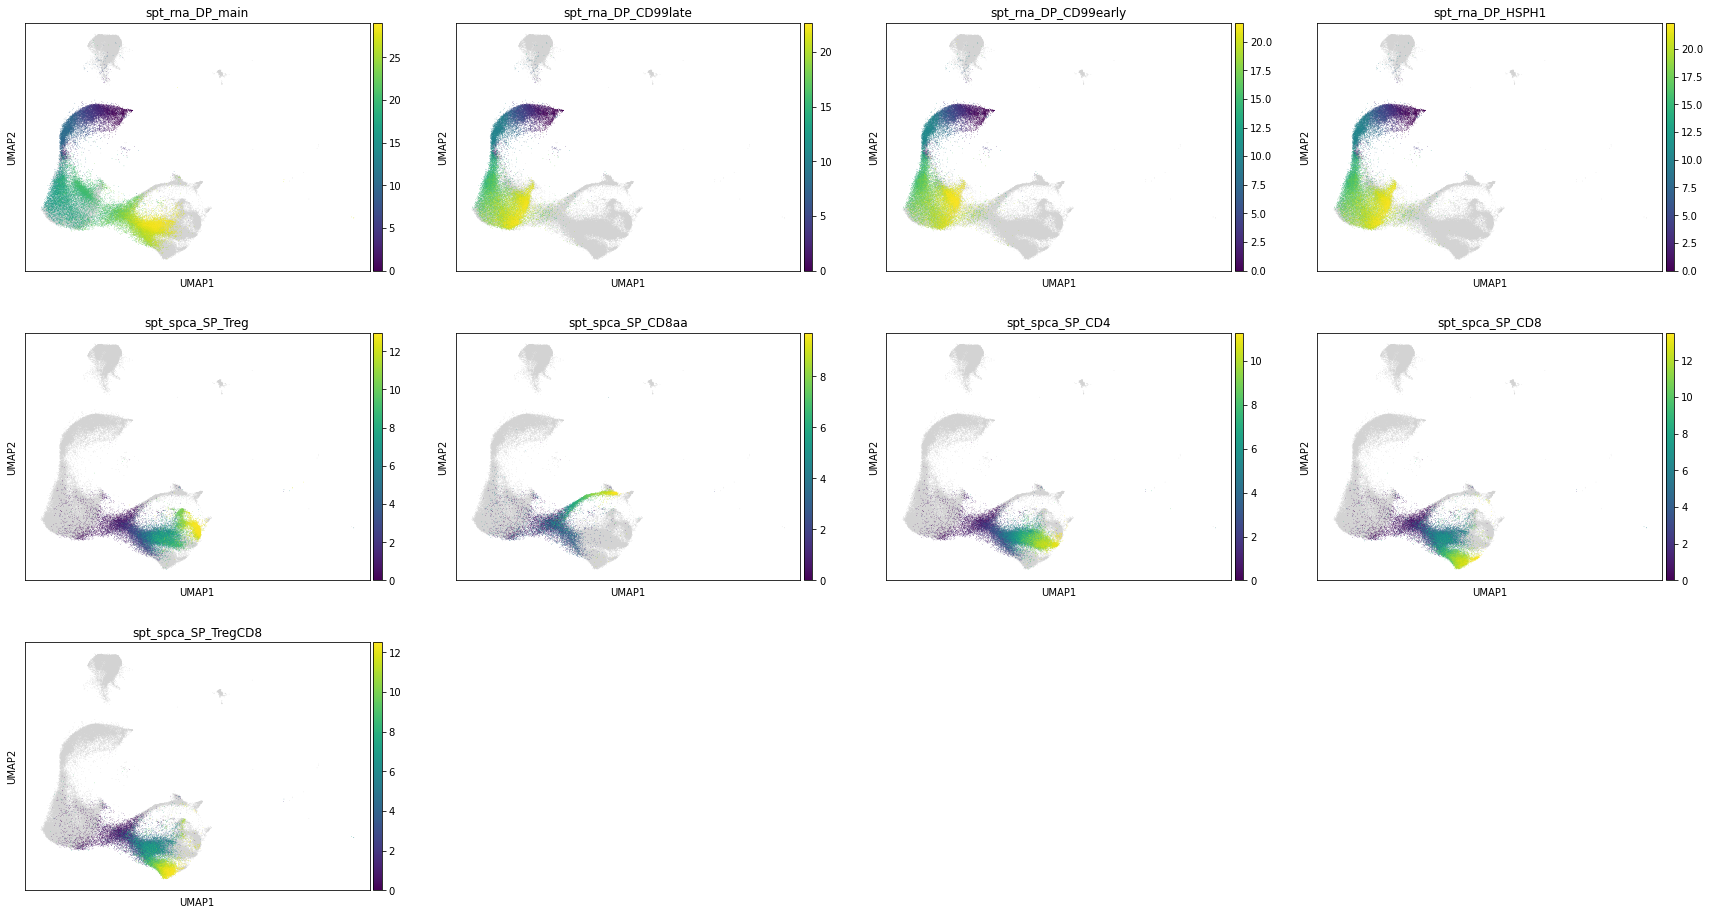

In [3]:
sc.pl.umap(gex,color=columns_containing_spt)

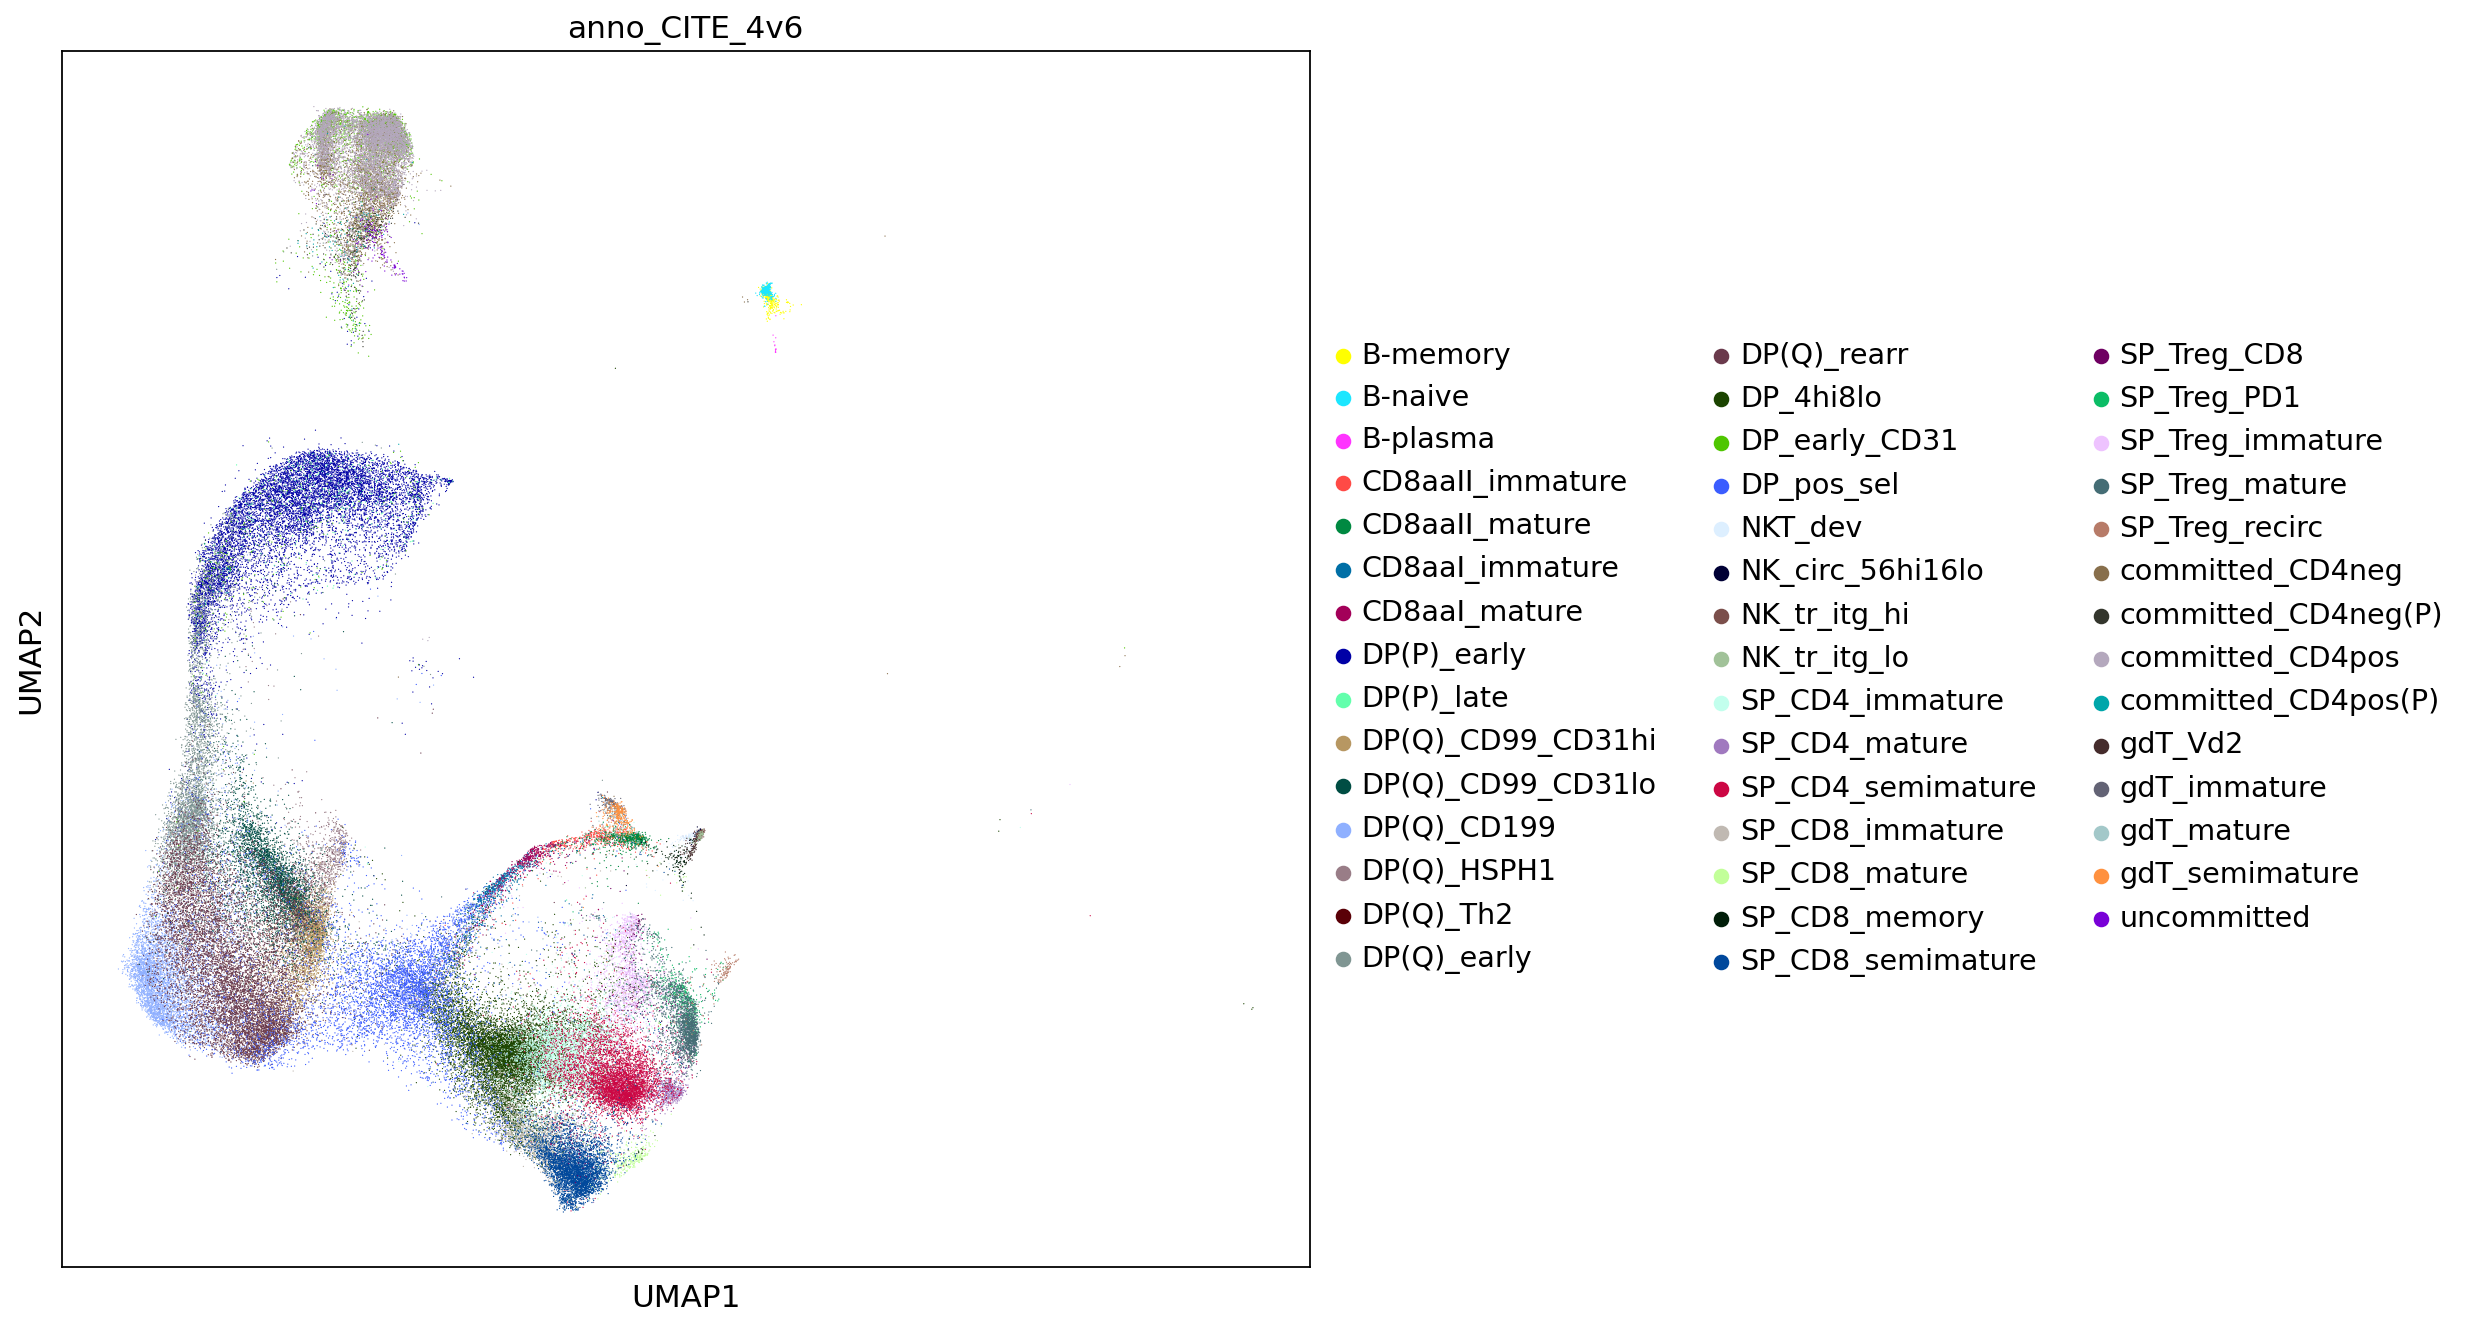

In [4]:
sc.set_figure_params(figsize=[10,10])
sc.pl.umap(gex,color=anno)

# run patcher on RNA

In [5]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
ibex_rna = sc.read_h5ad('pre_patcher_ibex_rna_T_only.h5ad')

In [20]:
# run pisser on individual samples without batch correctino 
import time
import scanpy as sc

# Get unique samples
unique_samples = ibex_rna.obs['sample'].unique()

# Dictionary to hold output for each sample
out_dict = {}

# Run the function for each sample and append the result to the list
for sample in unique_samples:
    if sample == 'Sample_06':
        start_time = time.time()
        # subset sample
        ibex_rna_sample = ibex_rna[ibex_rna.obs['sample'] == sample]
        # scale each sample 
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1000))
        ibex_rna_sample.X = scaler.fit_transform(ibex_rna_sample.X)
        # remove counts smaller than 1 
        mask = ibex_rna_sample.X < 5
        ibex_rna_sample.X[mask] = 0
        # run patcher 
        out_sample = ip.patch(
            iss=ibex_rna_sample,
            gex=gex,
            obs_to_take=[anno, 'cell_type_level_4'],
            cont_obs_to_take=columns_containing_spt,
            computation='cKDTree',
            neighbours=5,
            obsm_fraction=True,
            chunk_size=100000,
        )
        out_dict[sample] = out_sample
        end_time = time.time()
        print(f"Processed sample {sample} in {end_time - start_time} seconds")
out_rna = sc.concat(out_dict, join='outer')

        

/tmp/ipykernel_46713/3402396290.py:23: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_rna_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/iss_patcher/__init__.py:148: RuntimeWarning: divide by zero encountered in true_divide
  non_nan_weights = 1/non_nan_counts


Processed sample Sample_06 in 141.90340399742126 seconds


In [25]:
# generate transformed axis 
out_rna.obs['cma_v2_exp2'] = np.exp2(out_rna.obs['cma_v2']-0.16)-1

In [22]:
out_rna

AnnData object with n_obs × n_vars = 89503 × 36710
    obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch', 'n_genes', 'anno_CITE_4v6', 'anno_CITE_4v6_fraction', 'cell_type_level_4', 'cell_type_level_4_fraction', 'spt_rna_DP_main', 'spt_rna_DP_CD99late', 'spt_rna_DP_CD99early', 'spt_rna_DP_HSPH1', 'spt_spca_SP_Treg', 'spt_spca_SP_CD8aa', 'spt_spca_SP_CD4', 'spt_spca_SP_CD8', 'spt_spca_SP_TregCD8', 'spt_rna_DP_main_nanmean', 'spt_rna_DP_CD99late_nanmean', 'spt_rna_DP_CD99early_nanmean', 'spt_rna_DP_HSPH1_nanmean', 'spt_spca_SP_Treg_nanmean', 'spt_spca_SP_CD8aa_

In [ ]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/')
out_rna.write_h5ad('out_rna_ibex_rna_T_only_th_5_KNN5_peudo.h5ad')
out_rna.obs.to_csv('out_rna_ibex_rna_T_only_th_5_KNN5_peudo.csv')


# run patcher on RNA/cite

In [49]:
import os
import iss_patcher as ip
import anndata
import pandas as pd
import scanpy as sc
import numpy as np 

os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure4/')
ibex_cite = sc.read_h5ad('pre_patcher_ibex_cite_T_only.h5ad')
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/')
gex = sc.read_h5ad('pre_patcher_gex_T_only_clean.h5ad')
columns_containing_spt = [col for col in gex.obs.columns if 'spt' in col]


In [50]:
gex.X.data = np.round(gex.X.data)


In [51]:
anno = 'anno_CITE_4v6'
# run pisser on individual samples without batch correctino 
import time
import scanpy as sc

# Get unique samples
unique_samples = ibex_cite.obs['sample'].unique()

# Dictionary to hold output for each sample
out_dict = {}

# Run the function for each sample and append the result to the list
for sample in unique_samples:
    # if sample == 'Sample_06':
        start_time = time.time()
        # subset sample
        ibex_cite_sample = ibex_cite[ibex_cite.obs['sample'] == sample]
        # scale each sample 
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler(feature_range=(0, 1000))
        ibex_cite_sample.X = scaler.fit_transform(ibex_cite_sample.X)
        # remove counts smaller than 1 
        mask = ibex_cite_sample.X < 5
        ibex_cite_sample.X[mask] = 0
        # run patcher 
        out_sample = ip.patch(
            iss=ibex_cite_sample,
            gex=gex,
            obs_to_take=[anno, 'cell_type_level_4'],
            cont_obs_to_take=columns_containing_spt,
            computation='cKDTree',
            neighbours=5,
            chunk_size=100000,
        )
        out_dict[sample] = out_sample
        end_time = time.time()
        print(f"Processed sample {sample} in {end_time - start_time} seconds")

/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_06 in 549.8464002609253 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_07 in 567.8902599811554 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_08 in 559.790420293808 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_09 in 567.1566054821014 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_10 in 521.2286140918732 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_11 in 566.0875017642975 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_12 in 549.521555185318 seconds


/tmp/ipykernel_7285/898936608.py:24: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  ibex_cite_sample.X[mask] = 0
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Processed sample Sample_13 in 386.566602230072 seconds


In [52]:
# Concatenate all the results
out_cite = sc.concat(out_dict, join='outer')

In [53]:
out_dict

{'Sample_06': AnnData object with n_obs × n_vars = 89503 × 36709
     obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample', 'annotation_lv_0', 'annotation_lv_0_number', 'annotation_lv_1', 'annotation_lv_1_number', 'L2_dist_annotation_lv_0_Cortex', 'L2_dist_annotation_lv_0_Edge', 'L2_dist_annotation_lv_0_Medulla', 'L2_dist_annotation_lv_1_HS', 'L2_dist_annotation_lv_1_Other', 'L2_dist_annotation_lv_1_PVS', 'L2_dist_annotation_lv_1_Vessels', 'L2_dist_annotation_lv_1_unassigned', 'cma_v2', 'manual_bin_cma_v2', 'manual_bin_cma_v2_int', 'batch', 'n_genes', 'anno_CITE_4v6', 'anno_CITE_4v6_fraction', 'cell_type_level_4', 'cell_type_level_4_fraction', 'spt_rna_DP_main', 'spt_rna_DP_CD99late', 'spt_rna_DP_CD99early', 'spt_rna_DP_HSPH1', 'spt_spca_SP_Treg', 'spt_spca_SP_CD8aa', 'spt_spca_SP_CD4', 'spt_spca_SP_CD8', 'spt_spca_SP_TregCD8'
     var: 'cite',
 'Sample_07': AnnData object with n_obs × n_vars = 91532 × 36709
     obs: 'label', 'y', 'x', 'Unnamed: 0.1', 'Unnamed: 0', 'sample',

In [54]:
out_cite.obs['cma_v2_exp2'] = np.exp2(out_cite.obs['cma_v2']-0.16)-1

In [60]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/')
out_cite.write_h5ad('out_cite_ibex_cite_T_only_th_5_KNN5_peudo.h5ad')
out_cite.obs.to_csv('out_cite_ibex_cite_T_only_th_5_KNN5_peudo.csv')

In [ ]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure5/')
out_cite = sc.read_h5ad('out_cite_ibex_cite_T_only_th_5_KNN5_peudo.h5ad')
del out_cite.obsm
out_cite.obs.to_csv('out_cite_ibex_cite_T_only_th_5_KNN5_peudo.csv')
out_cite.write_h5ad('out_cite_ibex_cite_T_only_th_5_KNN5_peudo.h5ad')

In [62]:
gex.obs.to_csv('pre_patcher_gex_T_only_clean.csv')
